In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mne

from gait_modulation.file_reader import MatFileReader
from gait_modulation.data_processor import DataProcessor
from gait_modulation.viz import Visualise


# Loading the data

In [2]:
# Handle multiple patients with nested directories.
root_directory = '/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data'
mat_reader = MatFileReader(root_directory, max_workers=1)  #  adjust the number of workers for parallelism

# Read all data from nested folders of multiple patients and sessions
all_data = mat_reader.read_data()
n_sessions = len(all_data)

print(f"Number of sessions: {n_sessions}")

Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_HK59/26_10_22/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_4_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_2_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/organized_data/EM_FH_HK/PW_FH57/no_date/walking_sync_3_short.mat
Loading data from file: /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/mast

Number of samples removed: -14738
Number of seconds removed: -58.95 seconds
---> [0] (array([4]), array([8]))
Epochs info: <Epochs |  106 events (all good), -2 – 0 s, baseline off, ~2.4 MB, data loaded,
 'mod_start': 8
 'normal_walking': 98>
Number of epochs: 106
Plot saved as plots/0_event_classes.png
No trimming needed as the beginning of the data is already valid.
---> [1] (array([4]), array([6]))
Epochs info: <Epochs |  65 events (all good), -2 – 0 s, baseline off, ~1.5 MB, data loaded,
 'mod_start': 6
 'normal_walking': 59>
Number of epochs: 65
Plot saved as plots/1_event_classes.png
Number of samples removed: -2282
Number of seconds removed: -9.13 seconds
---> [2] (array([4]), array([15]))
Epochs info: <Epochs |  27 events (all good), -2 – 0 s, baseline off, ~644 kB, data loaded,
 'mod_start': 15
 'normal_walking': 12>
Number of epochs: 27
Plot saved as plots/2_event_classes.png
Number of samples removed: -7049
Number of seconds removed: -28.20 seconds
---> [3] (array([4]), array

Number of events,779
Events,mod_start: 146normal_walking: 633
Time range,-2.000 – 0.000 s
Baseline,off


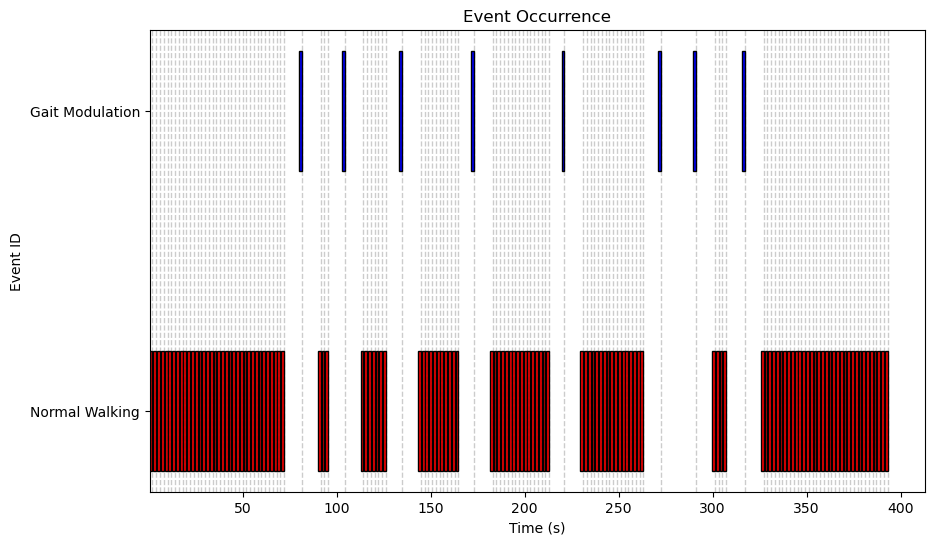

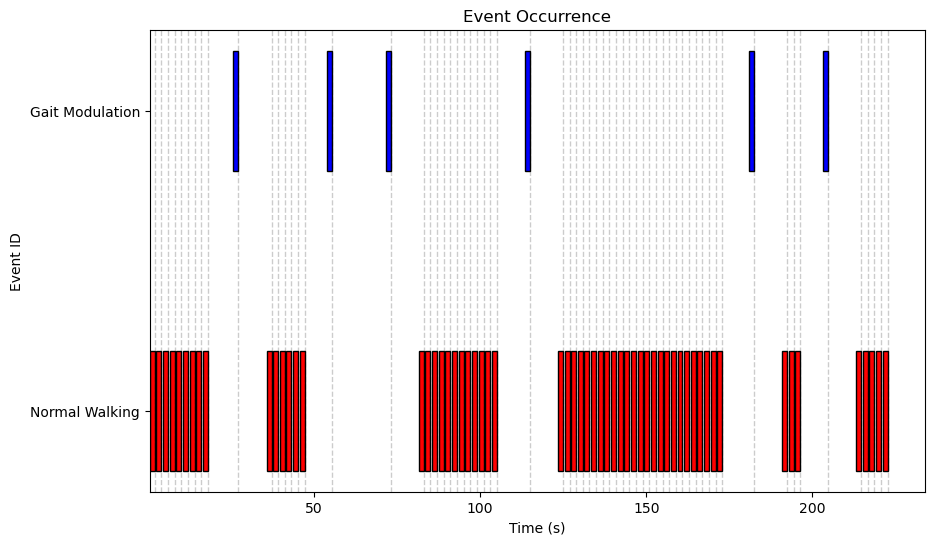

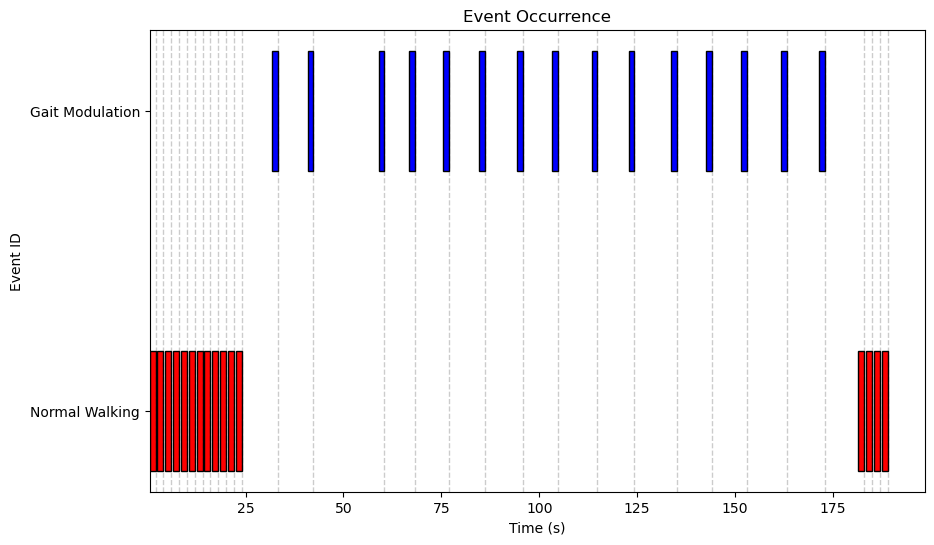

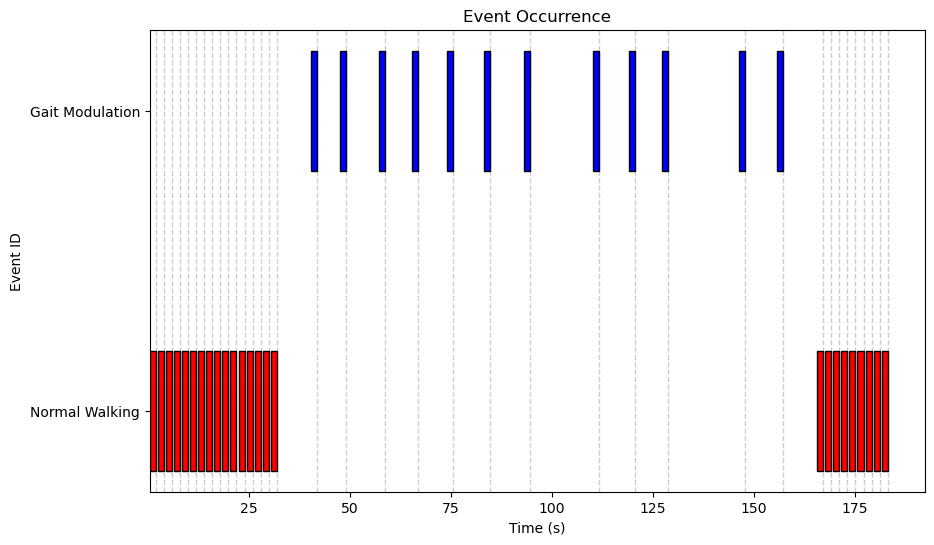

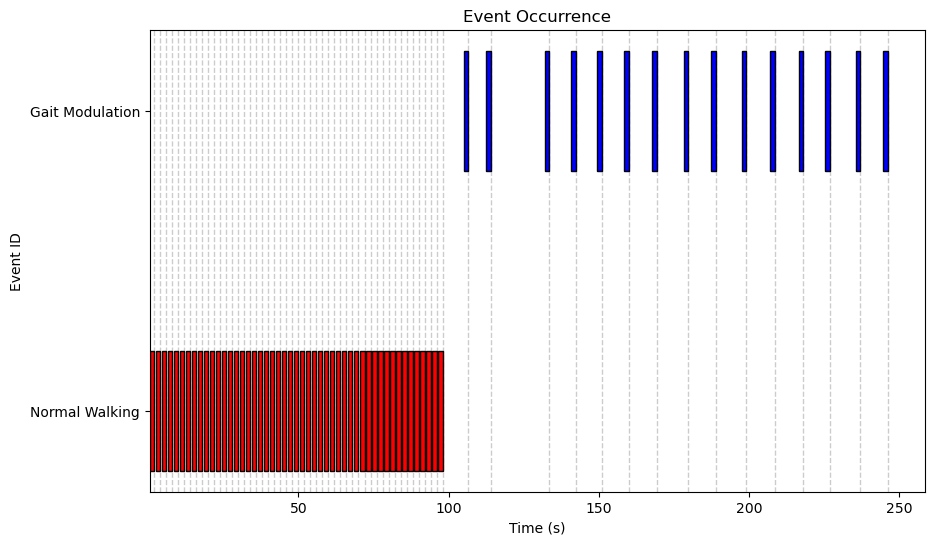

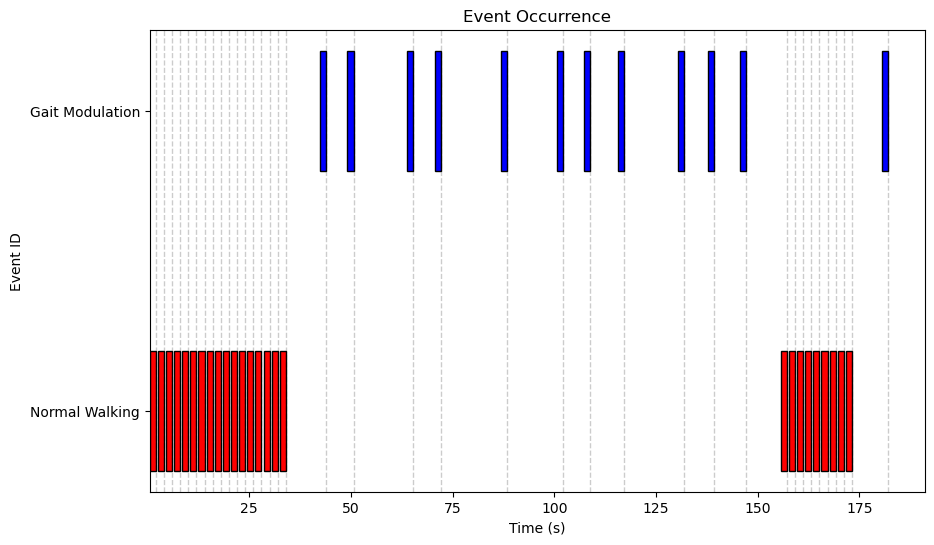

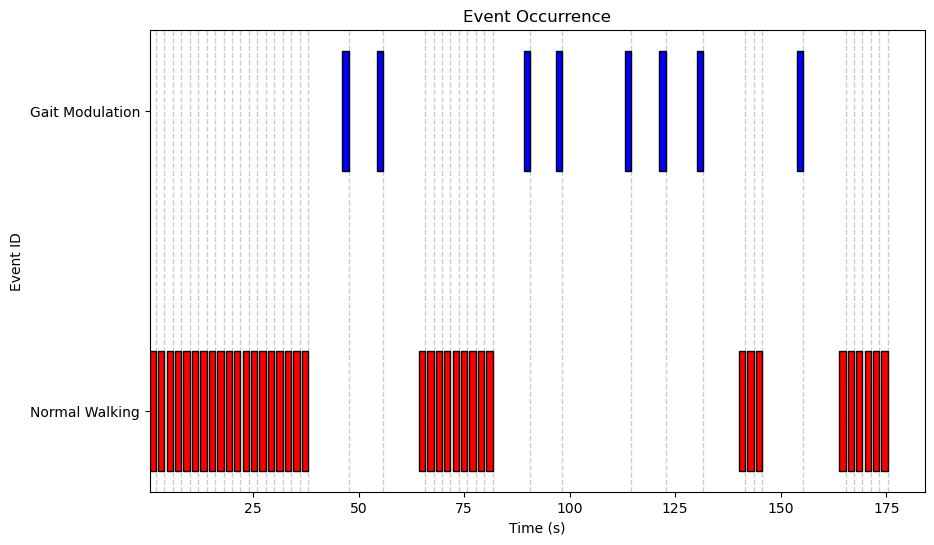

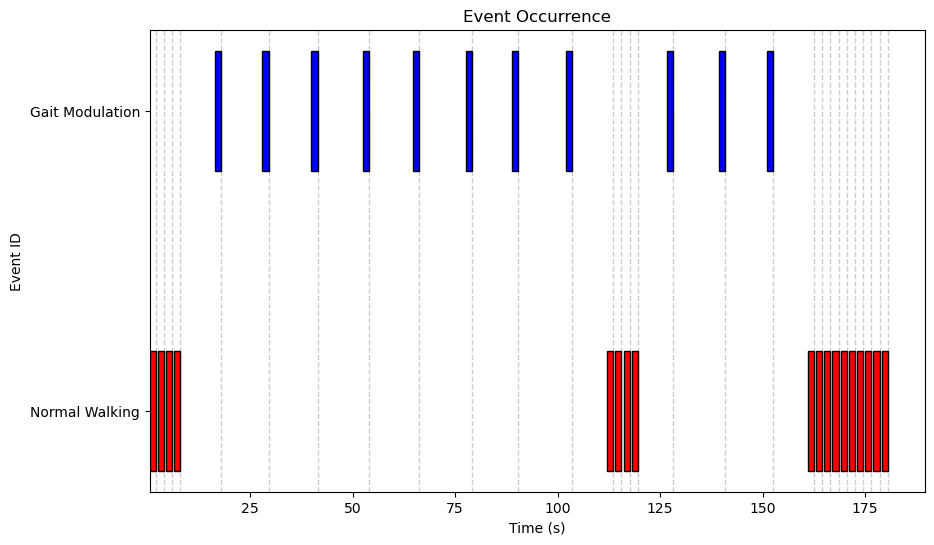

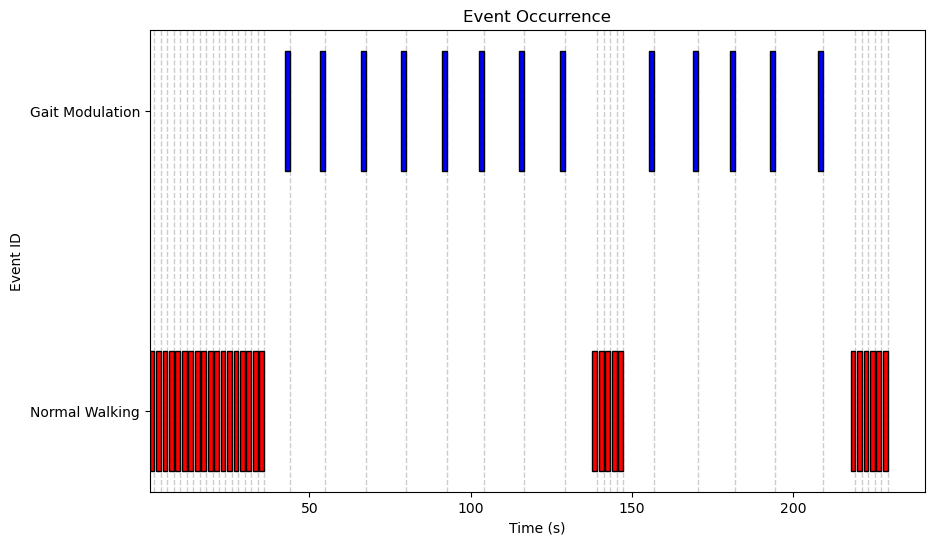

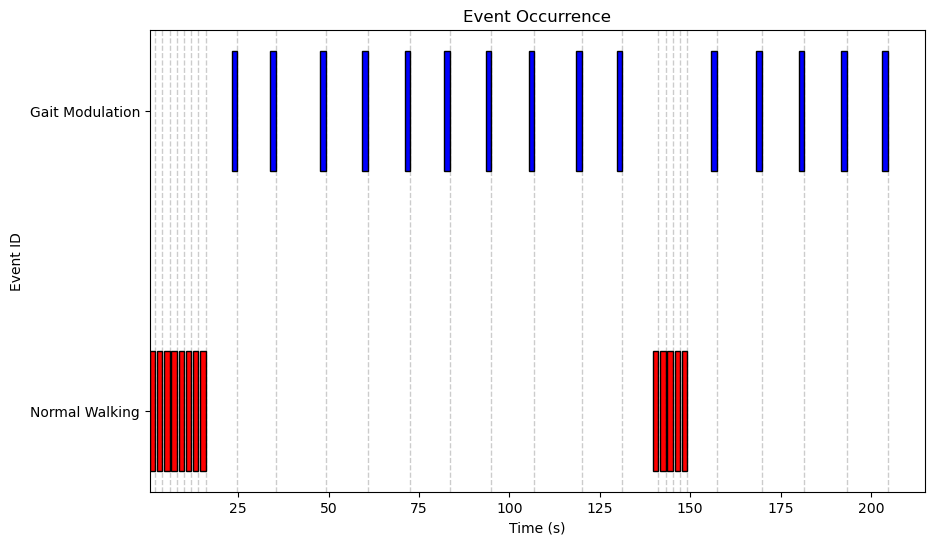

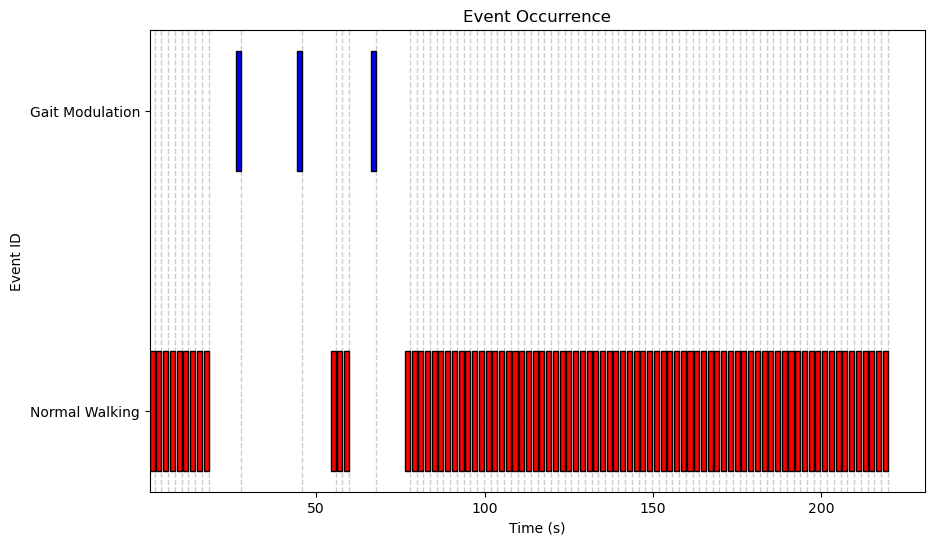

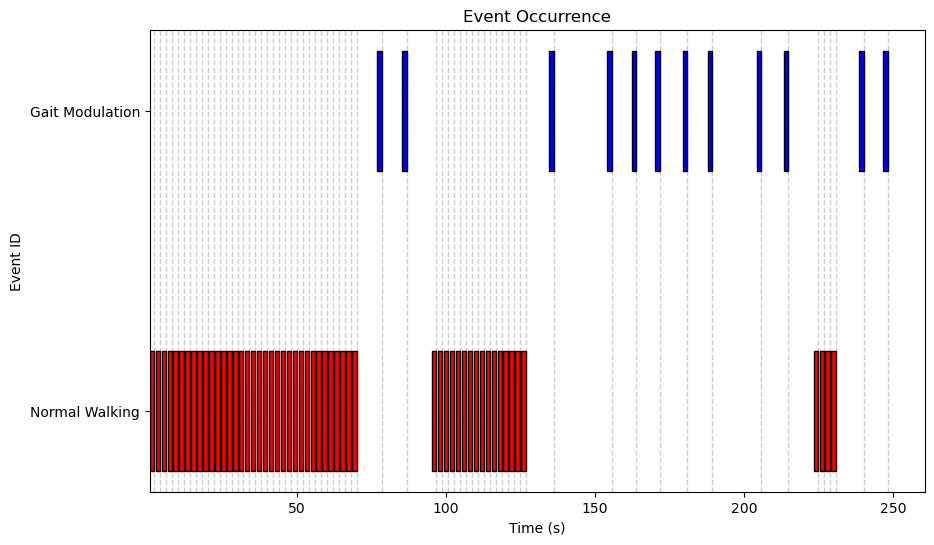

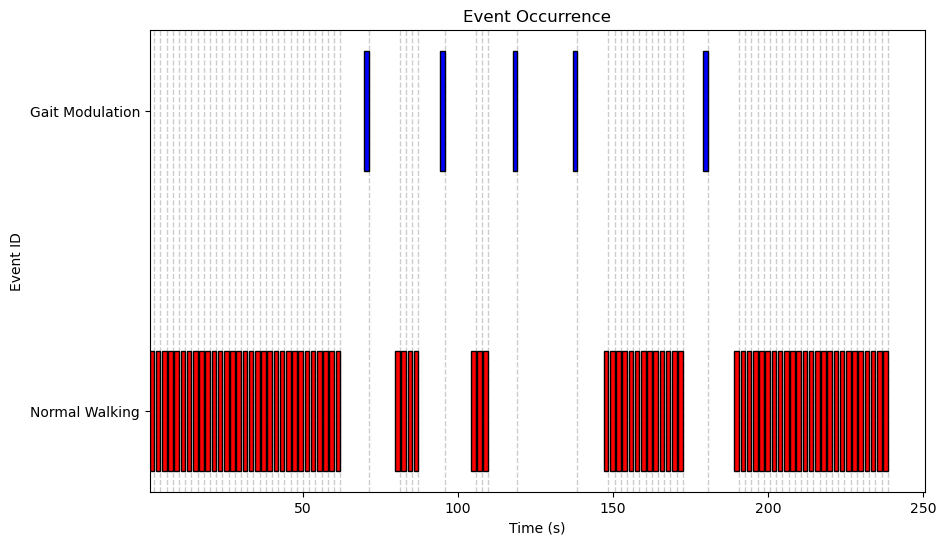

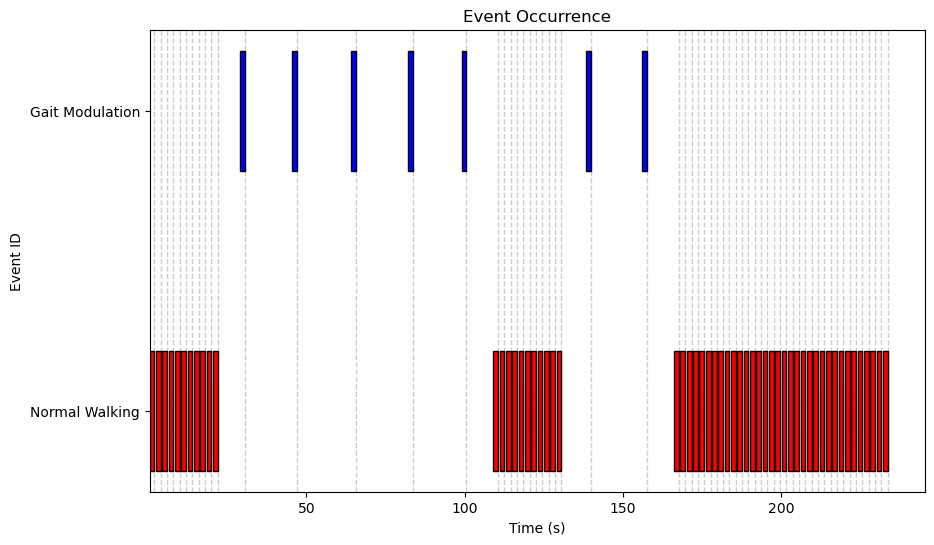

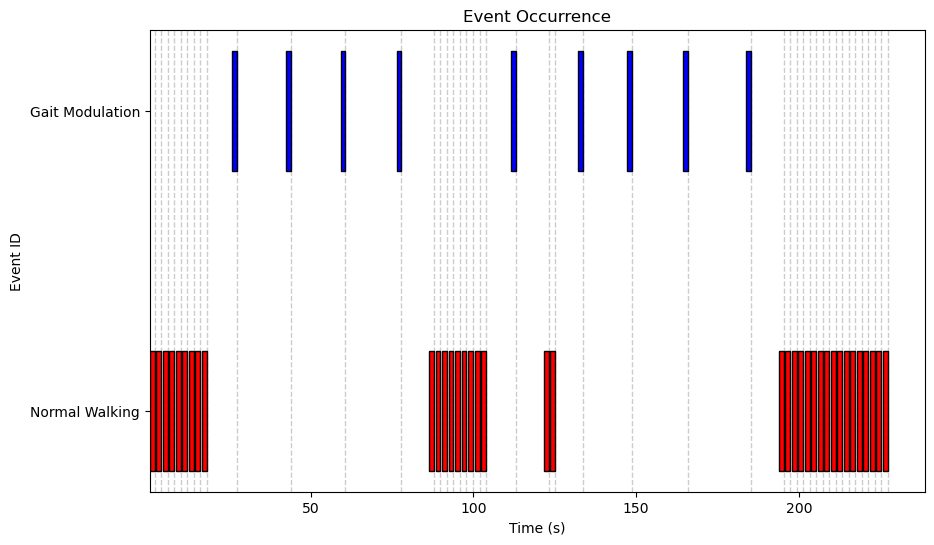

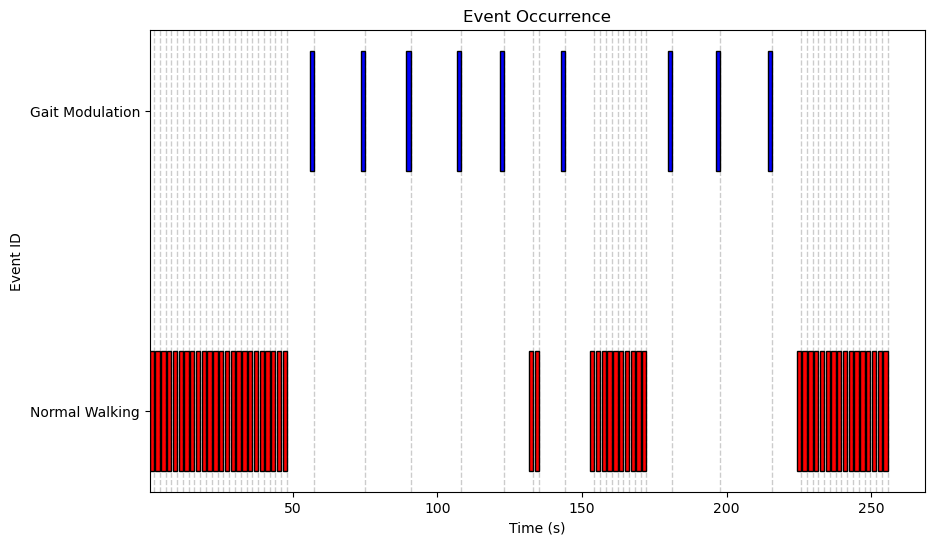

In [3]:
# Initialize lists to store epochs and events
# train_epochs_list = []
# train_events_list = []

# test_epochs_list = []
# test_events_list = []

# test_session_idx = [2, 3, 4]

# Access specific sessions for a patient
session = all_data[0] # pick any session e.g. first one to load the meta data

# Extract LFP meta data for subject/session
lfp_metadata = DataProcessor.np_to_dict(session['hdr_LFP'])

# Load LFP parameters
lfp_sfreq = lfp_metadata['Fs'].item()
lfp_ch_names = DataProcessor.rename_lfp_channels(lfp_metadata['labels'])
lfp_n_channels = lfp_metadata['NumberOfChannels'].item()

# Prepare for mne data structure
info = mne.create_info(ch_names=lfp_ch_names[0:6], sfreq=lfp_sfreq, ch_types='dbs', verbose=40)

# Select one event to work with: mod_start
event_of_interest = 'mod_start'
mod_start_event_id = 1

# Define parameters
epoch_tmin = -2.0
epoch_tmax = 0.0
epoch_duration_length = epoch_tmax - epoch_tmin
epoch_sample_length = int(epoch_duration_length * lfp_sfreq)
gap_duration = 10  # At least 10 seconds away from modulation events
gap_sample_length = int(gap_duration * lfp_sfreq)


# Define normal walking events
normal_walking_event_id = -1

# Define the event dictionary
event_dict = {
    'mod_start': mod_start_event_id,
    'normal_walking': normal_walking_event_id
}


epochs_list = []
events_list = []

for s in range(n_sessions):
    # # Access specific sessions for a patient
    session = all_data[s]

    # Extract events and lfp data of the subject/session
    lfp_data = session['data_LFP'] * 1e-6  # Convert microvolts to volts
    lfp_duration = lfp_data.shape[1] / lfp_sfreq
    n_samples = int(lfp_duration * lfp_sfreq)
    
    # lfp_raw = mne.io.RawArray(lfp_data, info, verbose=40)
    # lfp_raw.plot(start=0, duration=np.inf, remove_dc=False)
    # plt.show()

    # Handle events
    events_KIN = DataProcessor.np_to_dict(session['events_KIN'])
    events_before_trim, event_dict_before_trim = DataProcessor.create_events_array(events_KIN, lfp_sfreq)

    # Trim the data and adjust the event onsets accordingly
    lfp_data, events_after_trim = DataProcessor.trim_data(lfp_data, events_before_trim, lfp_sfreq)

    # Update raw data after trimming
    lfp_raw = mne.io.RawArray(lfp_data, info, verbose=40)


    events_mod_start = events_before_trim[events_before_trim[:, 2] == event_dict_before_trim[event_of_interest]]
    # events_mod_start = events_after_trim[events_after_trim[:, 2] == event_dict_before_trim[event_of_interest]]
    events_mod_start[:, 1] = s # mark the session nr
    
    print("--->", np.unique(events_mod_start[:, 1]), np.unique(events_mod_start[:, 2], return_counts=True))

    # Rename Gait Modulation Events
    events_mod_start[:, 2] = mod_start_event_id
        
    # Define normal walking events
    normal_walking_events = DataProcessor.define_normal_walking_events(
        normal_walking_event_id, events_mod_start,
        gap_sample_length, epoch_sample_length, n_samples
    )
    
    events_mod_start[:, 1] = s # mark the session nr
    normal_walking_events[:, 1] = s # mark the session nr
    

    # ## Remove artifacts from raw LFP data using ICA.
    # ica_n_components = 6 # 6 = n_channels.
    # ica = mne.preprocessing.ICA(n_components=ica_n_components, random_state=97, max_iter=800, verbose=40)
    # print(lfp_raw.ch_names)
    # ica.fit(lfp_raw)
    # raw_data_clean = ica.apply(lfp_raw, verbose=40) # Apply ICA to the raw data

    # Combine events and create epochs
    events, epochs = DataProcessor.create_epochs_with_events(
        lfp_raw,
        events_mod_start,
        normal_walking_events,
        mod_start_event_id,
        normal_walking_event_id,
        epoch_tmin,
        epoch_tmax,
        event_dict
    )
    # events[:, 1] = s # No need to mark the session nr for events again!
    epochs.events[:, 1] = s # mark the session nr
    # print("--------- ", np.unique(events[events[:, 1] == s][:, 2], return_counts=True))

    # # split epochs and events    
    # if s in test_session_idx:
    #     test_epochs_list.append(epochs)
    #     test_events_list.append(events)
    # else:
    #     train_epochs_list.append(epochs)
    #     train_events_list.append(events)
        
    epochs_list.append(epochs)
    events_list.append(events)
    
    # Visualise.plot_event_class_histogram(events=epochs.events, 
    #                                     event_dict=epochs.event_id, 
    #                                     show_fig=False, 
    #                                     save_fig=True,
    #                                     file_name=f'plots/{s}_hist.png')

    Visualise.plot_event_occurrence(events=events, 
                                    epoch_sample_length=epoch_sample_length, 
                                    lfp_sfreq=lfp_sfreq, 
                                    gait_modulation_event_id=mod_start_event_id, 
                                    normal_walking_event_id=normal_walking_event_id, 
                                    show_fig=False, 
                                    save_fig=True, 
                                    file_name=f'plots/{s}_event_classes.png')


# Combine all epochs into one object
# train_epochs = mne.concatenate_epochs(train_epochs_list)
# test_epochs = mne.concatenate_epochs(test_epochs_list)
epochs = mne.concatenate_epochs(epochs_list, verbose=40)

# Create a single event array by concatenating
# train_events = np.vstack(train_events_list)
# train_events = train_events[np.argsort(train_events[:, 0])]  # TODO: Sort by onset time
# test_events = np.vstack(test_events_list)
# test_events = test_events[np.argsort(test_events[:, 0])]  # TODO: Sort by onset time

events = np.vstack(events_list)
# events = events[np.argsort(events[:, 0])]  # TODO: Sort by onset time

# train & Test set
# Visualise.plot_event_class_histogram(events=epochs.events,
#                                     event_dict=epochs.event_id, 
#                                     show_fig=False, 
#                                     save_fig=True,
#                                     file_name=f'plots/epochs_hist.png')

# Visualise.plot_event_occurrence(events=epochs.events,
#                                 epoch_sample_length=epoch_sample_length, 
#                                 lfp_sfreq=lfp_sfreq, 
#                                 gait_modulation_event_id=mod_start_event_id, 
#                                 normal_walking_event_id=normal_walking_event_id, 
#                                 show_fig=False, 
#                                 save_fig=True, 
#                                 file_name=f'plots/epochs_event_classes.png')


# Preprocessing
## Apply band-pass filtering to the raw LFP data.
l_freq = 1
h_freq = 50
epochs.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin', verbose=40)

/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/gait_modulation/viz.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_labels, ha='right', fontsize=9)


Plot saved as plots/event_class_histogram.png


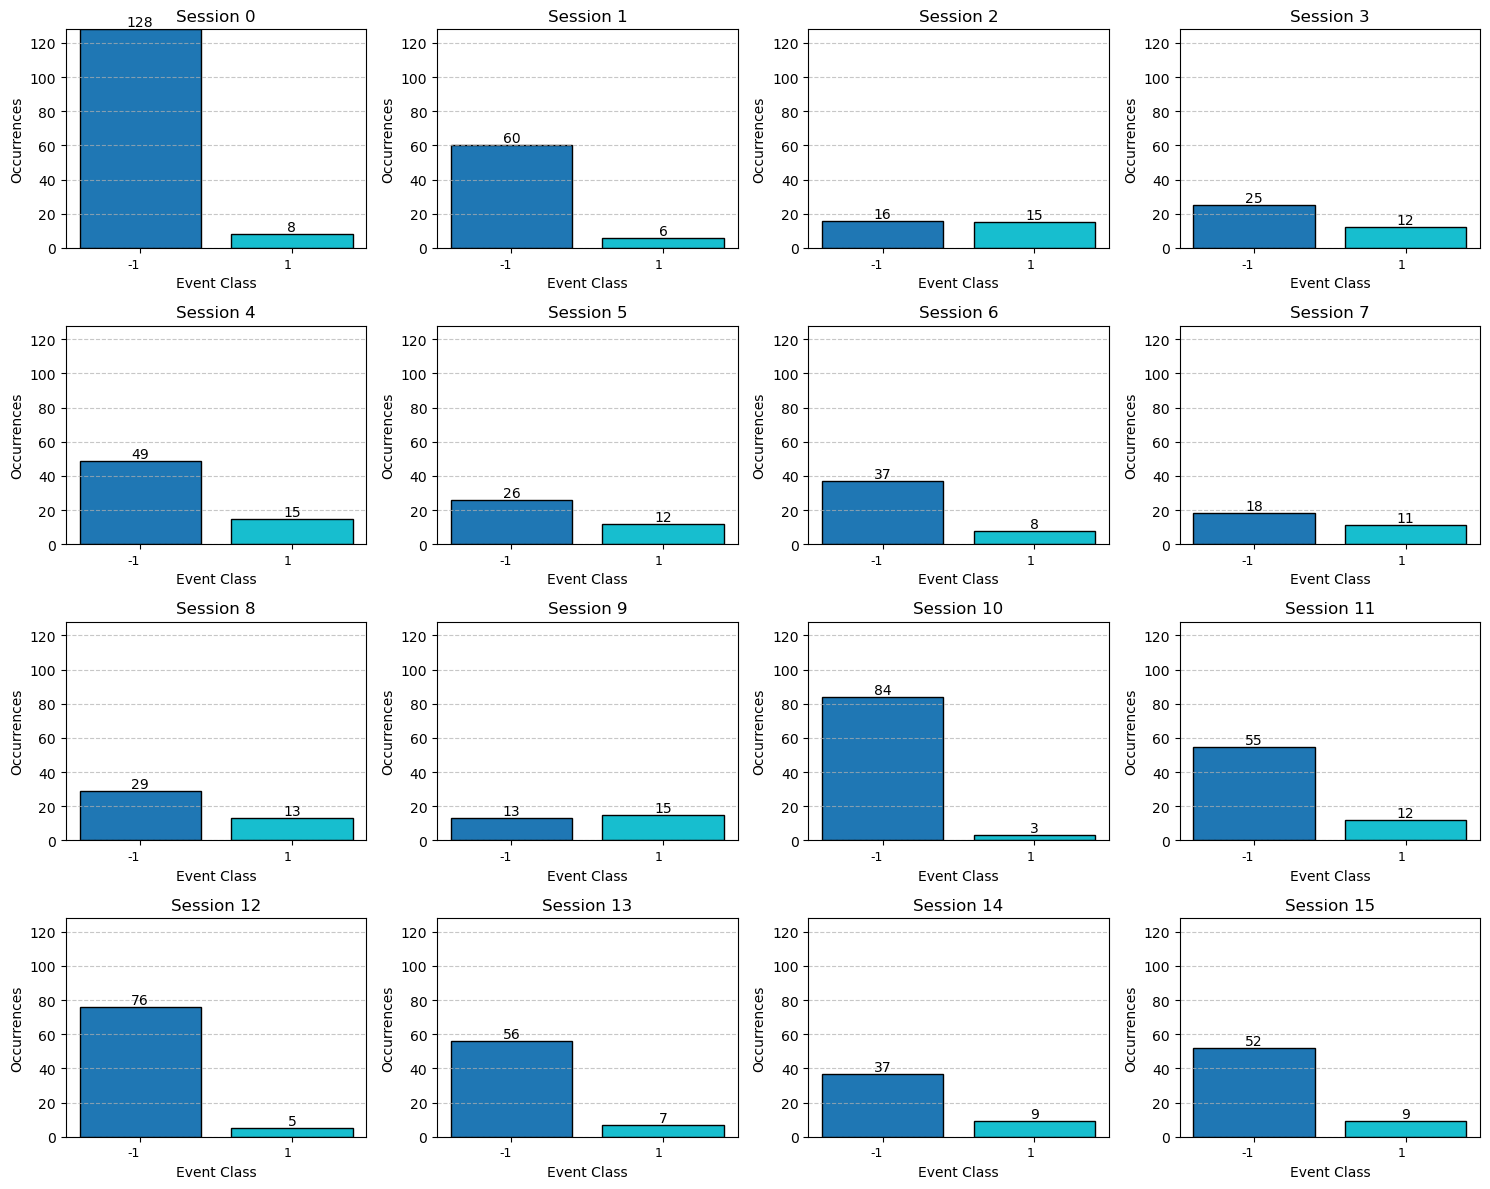

Plot saved as plots/epochs.event_class_histogram.png


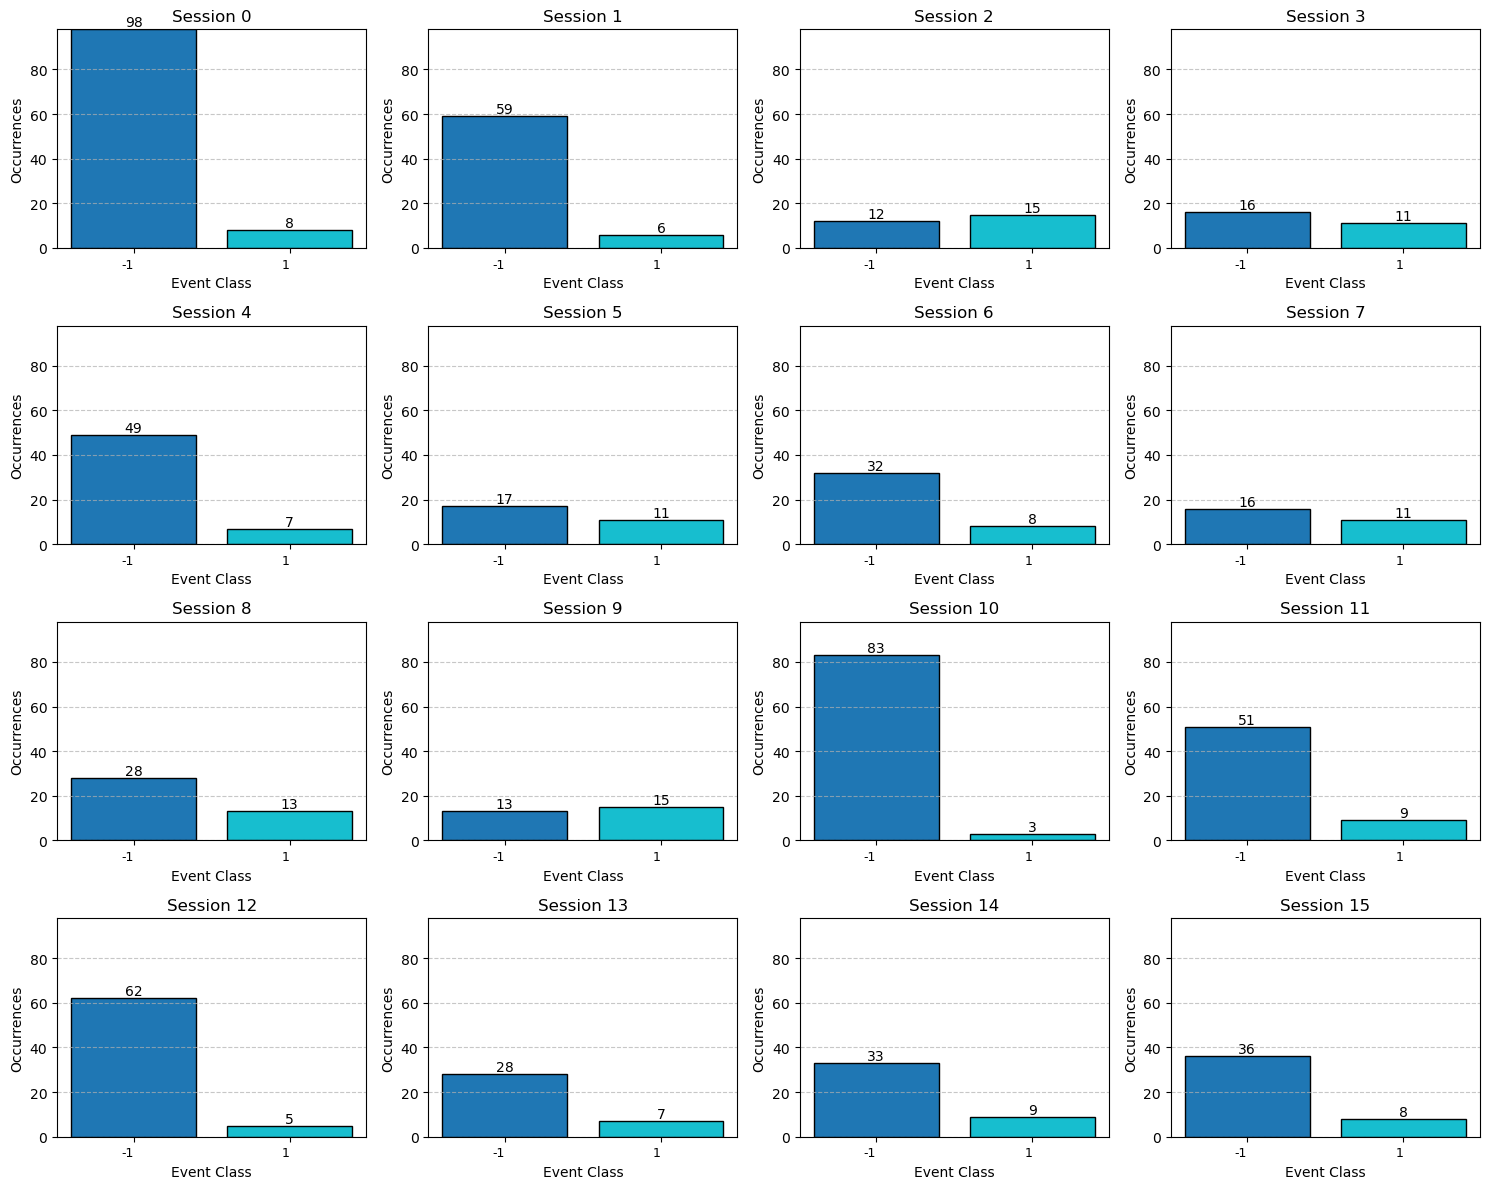

In [4]:
# for i in events:
#     print(i)

# fig, axes = plt.subplots(4, 4, figsize=(15,12))
# for s, ax in zip(range(n_sessions), axes.ravel()):
#     data = events[events[:, 1] == s]
    # ax.hist(data[:, 2])

# ax.set_xticks([-1, 1])
# plt.setp(axes, xticklabels=[-1, 1], xticks=[-1, 1])
# fig.supxlabel("Class label")
# fig.supylabel("Count")
# fig.tight_layout()

Visualise.plot_event_class_histogram(events=events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=True, 
                                    save_fig=True,
                                    file_name=f'plots/event_class_histogram.png')

Visualise.plot_event_class_histogram(events=epochs.events,
                                    event_dict=epochs.event_id,
                                    n_sessions=n_sessions,
                                    show_fig=True, 
                                    save_fig=True,
                                    file_name=f'plots/epochs.event_class_histogram.png')



In [5]:
s=0
print(np.unique(events[events[:, 1] == s][:, 2], return_counts=True))

(array([-1,  1]), array([128,   8]))


In [6]:
np.unique(epochs.events[epochs.events[:, 1] == 0][:, 2], return_counts=True)

(array([-1,  1]), array([98,  8]))

In [7]:
print(train_epochs.events.shape[0], train_events.shape[0])
print(test_epochs.events.shape[0], test_events.shape[0])

nlabels = train_epochs.events.shape[0] + test_epochs.events.shape[0]

print(train_epochs.events.shape[0] / nlabels)
print(test_epochs.events.shape[0] / nlabels)

NameError: name 'train_epochs' is not defined

In [ ]:
n_mod_labels = np.sum(train_all_epochs_combined.events[:, 2] == -1) + np.sum(test_all_epochs_combined.events[:, 2] == -1)

print(n_mod_labels)

print(np.sum(train_all_epochs_combined.events[:, 2] == -1))
print(np.sum(test_all_epochs_combined.events[:, 2] == -1))

print(np.sum(train_all_epochs_combined.events[:, 2] == -1) / n_mod_labels)
print(np.sum(test_all_epochs_combined.events[:, 2] == -1) / n_mod_labels)

# Pre-Processing

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


# Step 1: Train-test split
X_train = train_all_epochs_combined.get_data(copy=True)
X_test = test_all_epochs_combined.get_data(copy=True)

y_train = train_all_epochs_combined.events[:, -1]
y_test = test_all_epochs_combined.events[:, -1]

print(f'X_train shape: {X_train.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_train shape: {y_train.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_train == -1)} normal walking and {sum(y_train == 1)} event-related gait modulation')

print(f'X_test shape: {X_test.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_test shape: {y_test.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_test == -1)} normal walking and {sum(y_test == 1)} event-related gait modulation')

# Step 2: Flatten the X array (n_epochs, n_channels, n_samples_per_epoch) -> (n_epochs, n_channels * n_samples_per_epoch)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


# Step 3: Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Output the classification report
print(classification_report(y_test, y_pred))

# Filtering the data

In [ ]:
# raw psd
raw_spectrum = raw_data_clean.compute_psd(method='welch', fmin=1, fmax=50, n_fft=2048)

psd_arr = raw_spectrum.get_data()
psd_freqs = raw_spectrum.freqs
print(raw_data_clean.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}  # channels x frequencies")
print(f"Frequencies has shape: {psd_freqs.shape}  # frequencies")

raw_spectrum.plot()

In [ ]:
raw_spectrum.get_data().shape, raw_data_clean.get_data().shape

In [ ]:
# epochs psd: Train set
train_epoch_spectrum = train_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = train_epoch_spectrum.get_data()
psd_freqs = train_epoch_spectrum.freqs

print(train_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

train_epoch_spectrum.plot(average=False)

In [ ]:
train_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
train_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
# epochs psd: Test set
test_epoch_spectrum = test_all_epochs_combined.compute_psd(method='welch', fmax=50)

psd_arr = test_epoch_spectrum.get_data()
psd_freqs = test_epoch_spectrum.freqs

print(test_all_epochs_combined.get_data().shape)
print(f"PSD data has shape: {psd_arr.shape}")
print(f"Frequencies has shape: {psd_freqs.shape}")

test_epoch_spectrum.plot(average=False)

In [ ]:
test_epoch_spectrum['mod_start'].plot(average=False)

In [ ]:
test_epoch_spectrum['normal_walking'].plot(average=False)

In [ ]:
train_all_epochs_combined.get_data().shape, train_epoch_spectrum.get_data().shape



# train_all_epochs_combined.events[:, -1].shape, test_all_epochs_combined.events[:, -1].shape

## Logistic Regression based on PSD

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report


# Step 1: Train-test split
X_train = train_epoch_spectrum.get_data()
X_test = test_epoch_spectrum.get_data()

y_train = train_all_epochs_combined.events[:, -1]
y_test = test_all_epochs_combined.events[:, -1]

print(f'X_train shape: {X_train.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_train shape: {y_train.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_train == -1)} normal walking and {sum(y_train == 1)} event-related gait modulation')

print(f'X_test shape: {X_test.shape}')# (n_epochs, n_channels, n_samples_per_epoch)
print(f'y_test shape: {y_test.shape}')  # (n_epochs,)
print(f'--- Total epochs: {len(y_train)}, with {sum(y_test == -1)} normal walking and {sum(y_test == 1)} event-related gait modulation')

# Step 2: Flatten the X array (n_epochs, n_channels, n_samples_per_epoch) -> (n_epochs, n_channels * n_samples_per_epoch)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])


# Step 3: Standardize the features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train a Logistic Regression model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Output the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# ICA raw
## CODE GOES HERE
ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
ica_95PCA.fit(inst=lfp_raw)
# ica_95PCA.plot_sources(inst=lfp_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# raw_ica_excluded = ica.apply(inst=lfp_raw.copy())
# raw_ica = ica.apply(inst=lfp_raw.copy())

# raw_ica_excluded.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')
# raw_ica.plot(scalings='auto', start=12, duration=4, title='clraned sensor signals (without noise)')

In [ ]:
# # ICA rpochs
# ## CODE GOES HERE
# ica_95PCA = mne.preprocessing.ICA(n_components=0.95, random_state=0)
# ica_95PCA.fit(inst=epochs_raw)
# ica_95PCA.plot_sources(inst=epochs_raw, title="ICA sources (95% variance PCA components)");

In [ ]:
# # Compute variance explained by PCA components
# explained_variance = ica.pca_explained_variance_ / np.sum(ica.pca_explained_variance_)

# print(f"Variance explained by PCA components: {explained_variance}")
# print(f"Variance explained by first 4 PCA components: {np.sum(explained_variance[:4]) * 100:.2f}%")

In [ ]:
# ica = mne.preprocessing.ICA(random_state=0)
# ica.fit(raw_sensors)

# # Remove the first ICA component (the random noise) from the data
# raw_cleaned = ica.apply(inst=raw_sensors.copy(), exclude=[1,2])
# raw_cleaned.plot(scalings='auto', title='clraned sensor signals (without noise)')

In [ ]:
epochs_raw["mod_start"].plot_image(combine="mean");

In [ ]:
mne.viz.plot_epochs_image(
    epochs_raw['mod_start'],
    picks=[0, 1, 2, 3, 4, 5],
    sigma=0.5,
    # combine="mean",
    # evoked=True
)

# Evoked

evoked_0 = epochs_raw['trial_start'].average()
evoked_4 = epochs_raw['mod_start'].average()

## Global Field Power (GFP)

The GFP is the population standard deviation of the signal across channels.

In [ ]:
fig0 = evoked_0.plot(gfp=True);
fig1 = evoked_1.plot(gfp=True);

In [ ]:
evoked_0.plot(gfp="only");
evoked_1.plot(gfp="only");

In [ ]:
gfp = evoked_0.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_0.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_0.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

In [ ]:
gfp = evoked_1.data.std(axis=0, ddof=0)

# Reproducing the MNE-Python plot style seen above
fig, ax = plt.subplots()
ax.plot(evoked_1.times, gfp * 1e6, color="lime")
ax.fill_between(evoked_1.times, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (s)", ylabel="GFP (µV)")

# # Time-frequency analysis

In [ ]:
freqs = np.arange(2, 50, 2) # Frequencies from 2 to 50 Hz
n_cycles = freqs / 2 # Number of cycles in Morlet wavelet


In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['mod_start'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

In [ ]:
freqs = np.arange(7, 30, 3)
power = epochs_raw['min_vel'].compute_tfr(
    "morlet", 
    n_cycles=2,
    return_itc=False, 
    freqs=freqs,
    decim=3,
    average=True
)
power.plot(title='auto')

# CSD

In [ ]:
csd_fft = mne.time_frequency.csd_fourier(train_all_epochs_combined, fmin=1, fmax=50)
csd_mt = mne.time_frequency.csd_multitaper(train_all_epochs_combined, fmin=1, fmax=50, adaptive=True)
frequencies = np.arange(1,51, 1)
csd_wav = mne.time_frequency.csd_morlet(train_all_epochs_combined, frequencies, decim=1)

In [ ]:
plot_dict = {
    "Short-time Fourier transform": csd_fft,
    "Adaptive multitapers": csd_mt,
    "Morlet wavelet transform": csd_wav,
}
for title, csd in plot_dict.items():
    (fig,) = csd.mean().plot()
    fig.suptitle(title)